classification of cats and dogs using svm

In [30]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from skimage.feature import hog
import glob
import seaborn as sns

IMAGE_SIZE = 128
limit= 2000  # 1000 cats + 1000 dogs
data_dir = '/content/train'

def ext_hog_features(image_path):
  try:
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features, _ = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), block_norm='L2-Hys',
                      visualize=True)
    return features
  except:
      return None
X,y=[],[]
count={'cat':0, 'dog':0}
max=limit // 2
image_paths = glob.glob(os.path.join(data_dir, '**', '*.jpg'), recursive=True)
for fpath in image_paths:
    fname = os.path.basename(fpath)
    if 'cat' in fname:
        label = 'cat'
    elif 'dog' in fname:
        label = 'dog'
    else:
        continue

    if count[label] >= max:  # Limit number of images per class
        continue

    features = ext_hog_features(fpath)  # Extract HOG features

    if features is not None:
        X.append(features)
        y.append(label)
        count[label] += 1

    if sum(count.values()) >= limit:  # Stop after limit reached
        break

print(f"Extracted {len(X)} features: {count['cat']} cats, {count['dog']} dogs")


Extracted 2000 features: 1000 cats, 1000 dogs


step by step breakdoown

encoding labels and applying pca for dimensionalty reduction

In [27]:
X=np.array(X)
le=LabelEncoder()
y_encoded= le.fit_transform(y)

pca=PCA(n_components=150)
X_pca=pca.fit_transform(X)
print("shape after applying pca ",X_pca.shape)

shape after applying pca  (2000, 150)


training svm with gridsearhcv

In [28]:
params = {
    'C': [1, 10],
    'gamma': ['scale', 0.01],
    'kernel': ['linear', 'rbf']
}

grid = GridSearchCV(SVC(), params, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_pca, y_encoded)

best_svm = grid.best_estimator_
print(" Best Parameters:", grid.best_params_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
 Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


Model Evaluation

accuracy: 0.9415
              precision    recall  f1-score   support

         cat       0.96      0.93      0.94      1000
         dog       0.93      0.96      0.94      1000

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



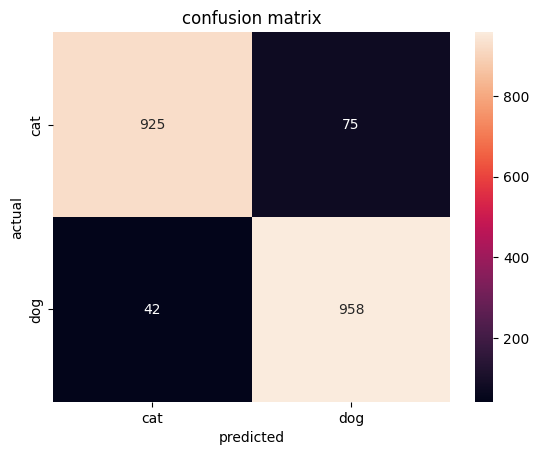

In [29]:
y_pred =  best_svm.predict(X_pca)
print("accuracy:", accuracy_score(y_encoded,y_pred))
print(classification_report(y_encoded, y_pred, target_names=le.classes_))
cm=confusion_matrix(y_encoded,y_pred)

sns.heatmap(cm,annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("confusion matrix")
plt.xlabel("predicted")
plt.ylabel("actual")
plt.show()

In [39]:
TEST_DIR ='/content/test/test1'


In [40]:
def extract_hog_features(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    image = cv2.resize(image, (128, 128))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features, _ = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), block_norm='L2-Hys',
                      visualize=True)
    return features


In [41]:
test_image_paths = sorted(glob.glob(os.path.join(TEST_DIR, '*.jpg')))
print(f"🔍 Found {len(test_image_paths)} test images.")

test_features = []
test_file_names = []

for fpath in test_image_paths[:1000]:  # Optional limit
    features = extract_hog_features(fpath)
    if features is not None:
        features_pca = pca.transform([features])  # Use PCA from training
        test_features.append(features_pca[0])
        test_file_names.append(os.path.basename(fpath))


🔍 Found 0 test images.


In [38]:
test_features = np.array(test_features)

if len(test_features) == 0:
    print("⚠️ No valid features found. Check if images were read properly.")
else:
    test_predictions = best_svm.predict(test_features)
    test_labels = le.inverse_transform(test_predictions)


⚠️ No valid features found. Check if images were read properly.


In [50]:
import os
import glob
import cv2
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt

# Set your test directory path
TEST_DIR = '/content/test/test1'

# HOG feature extraction (same as training)
def extract_hog_features(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    image = cv2.resize(image, (128, 128))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features, _ = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), block_norm='L2-Hys',
                      visualize=True)
    return features

# Load test images
test_image_paths = sorted(glob.glob(os.path.join(TEST_DIR, '*.jpg')))
print(f" Found {len(test_image_paths)} test images.")

test_features = []
test_file_names = []

for fpath in test_image_paths[:1000]:  # Optional limit
    features = extract_hog_features(fpath)
    if features is not None:
        features_pca = pca.transform([features])
        test_features.append(features_pca[0])
        test_file_names.append(os.path.basename(fpath))

# Convert features to NumPy array
test_features = np.array(test_features)

if len(test_features) == 0:
    print("No valid features found. Check if images were read properly.")
else:
    # Predict using trained SVM
    test_predictions = best_svm.predict(test_features)
    test_labels = le.inverse_transform(test_predictions)

    # Show first 10 predictions with image preview
    print("\nSample Predictions:")
    for i, (fname, label) in enumerate(list(zip(test_file_names, test_labels))[:10]):
        print(f"{fname}: 🔮 Predicted - {label}")

        img_path = os.path.join(TEST_DIR, fname)
        img = cv2.imread(img_path)
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img_rgb)
            plt.title(f"Prediction: {label}")
            plt.axis('off')
            plt.show()
        else:
            print(f" Could not read image: {fname}")

Output hidden; open in https://colab.research.google.com to view.

As the accuray is 94% some predictions are missclasified and others are properly classified

In [46]:
import zipfile

# If uploaded as test1.zip (as in original Kaggle dataset), unzip like this:
test_zip_path = '/content/test1.zip'  # Update path if needed

with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/test')  # Extract into /content/test
print("✅ Extracted test1.zip to /content/test")


✅ Extracted test1.zip to /content/test
